# Generative data

The goal here is to simulate data under a generative model and then to assess the ability of our probabilistic models to estimate the correct parameter values in their posteriors.

We fit a hierarchical linear model in pymc3 as in:

- [https://twiecki.io/blog/2014/03/17/bayesian-glms-3/](https://twiecki.io/blog/2014/03/17/bayesian-glms-3/)  
- [https://discourse.pymc.io/t/help-with-censored-regression/4617/21](https://discourse.pymc.io/t/help-with-censored-regression/4617/21)  
- [https://docs.pymc.io/notebooks/Diagnosing_biased_Inference_with_Divergences.html](https://docs.pymc.io/notebooks/Diagnosing_biased_Inference_with_Divergences.html)

In [1]:
# conda install toytree pymc3 -c conda-forge

In [2]:
import itertools
import pandas as pd
import numpy as np
import toytree
import toyplot
import arviz as az
import pymc3 as pm
from pymc3.distributions.dist_math import normal_lccdf, normal_lcdf

In [3]:
toyplot.config.autoformat = "png"

### The phylogeny
We will simulate data on a phylogeny with four clades that have different rates of evolution of reproductive incompatibility, colored below. 

In [4]:
# generate a balanced 128-tip tree with root 30Mya and randomly slide edge lengths
TREE = toytree.rtree.baltree(ntips=128, treeheight=30e6)
TREE = TREE.mod.node_slider(prop=0.7)

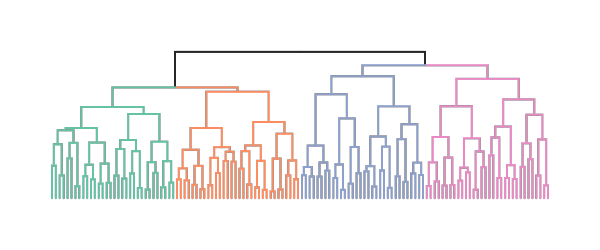

In [5]:
# draw and color the four major clades
TREE.draw(
    layout='d', 
    width=600,
    tip_labels=False,
    edge_colors=TREE.get_edge_values_mapped({
        248: toytree.colors[0],
        249: toytree.colors[1],
        250: toytree.colors[2],
        251: toytree.colors[3],
    }),
);

### Linear model of RI with time

We will model incompatibility as something that accumulates linearly with time since divergence, with the rate parameter varying among the four clades. The question is: "does genetic distance predict the level of genetic incompatibility between species?". To implement a hierarchical model we are additionally asking: "Does information about which clade the species is from improve estimation?"


$$ Y_{ij} = \alpha + (\beta + \psi_i + \psi_j) X_{ij} + \sigma $$

$ \alpha$ = intercept    
$ \beta$ = base RI velocity  
$ X_{ij}$ = genetic divergence  
$ Y_{ij}$  = Reproductive incompatibility  
$ \psi$ = species RI velocity  
$ \sigma$ = error

In [23]:
# True param values
𝛼_mean = 0.05
𝛼_std = 0.005
𝛽_mean = 1.5
𝛽_std = 0.05
𝜓_mean = 0.0
𝜓_std = 0.33
𝜎_std = 0.05

In [24]:
# 4 different clade effects on rate of RI (used for partial-pooling data)
𝜓_0_mean = 1.0
𝜓_0_std = 0.2
𝜓_1_mean = 0.5
𝜓_1_std = 0.1
𝜓_2_mean = -0.5
𝜓_2_std = 0.05
𝜓_3_mean = -1.0
𝜓_3_std = 0.1

## Generate species-level data

Generate a true RI velocity for each species under all three models.

In [25]:
SPECIES_DATA = pd.DataFrame({
    "𝛽": np.random.normal(𝛽_mean, 𝛽_std, 128),
    "𝜓": np.random.normal(𝜓_mean, 𝜓_std, 128),
    "𝜓_x": np.concatenate([
        np.random.normal(𝜓_0_mean, 𝜓_0_std, 32),
        np.random.normal(𝜓_1_mean, 𝜓_1_std, 32),
        np.random.normal(𝜓_2_mean, 𝜓_2_std, 32),
        np.random.normal(𝜓_3_mean, 𝜓_3_std, 32),
    ]),
    "gidx": np.concatenate([
        np.repeat(0, 32),
        np.repeat(1, 32),
        np.repeat(2, 32),
        np.repeat(3, 32),
    ]),
})

# species RI velocity is the base velocity times species specific 
SPECIES_DATA["velo"] = SPECIES_DATA["𝛽"] + SPECIES_DATA["𝜓"]
SPECIES_DATA["velo_x"] = SPECIES_DATA["𝛽"] + SPECIES_DATA["𝜓_x"]
SPECIES_DATA.head()

,𝛽,𝜓,𝜓_x,gidx,velo,velo_x
0,1.394193,-0.128617,0.921245,0,1.265576,2.315438
1,1.532257,-0.603485,1.151882,0,0.928772,2.684138
2,1.543099,0.065116,1.224223,0,1.608215,2.767322
3,1.488068,0.326682,0.866106,0,1.814750,2.354174
4,1.555553,0.327205,0.875767,0,1.882757,2.431320


## Generate crossing data

In [26]:
NSAMPLES = 5000
RNG = np.random.default_rng(123)

In [27]:
# sample random cross pairs
crosses = RNG.choice(TREE.get_tip_labels(), size=(NSAMPLES, 2))

# translate names to indices
name2nidx = TREE.get_feature_dict("name", "idx")

# randomly choose tip idx numbers maternal and paternal
data = pd.DataFrame({
    "sp0": crosses[:, 0],
    "sp1": crosses[:, 1],
    "sidx0": [name2nidx[i] for i in crosses[:, 0]],
    "sidx1": [name2nidx[i] for i in crosses[:, 1]],
    "geo_overlap": 0.,
    "genetic_dist": 0.,
})

In [28]:
def get_dist(tree, idx0, idx1):
    "returns the genetic distance between two nodes on a tree"
    dist = tree.treenode.get_distance(
        tree.idx_dict[idx0], 
        tree.idx_dict[idx1],
    )
    return dist

In [29]:
# calc genetic distances and normalize to range(0, 1)
data['genetic_dist'] = [get_dist(TREE, *data.iloc[idx, [2, 3]]) / 2 for idx in data.index]
data['genetic_dist'] += data['genetic_dist'].min()
data['genetic_dist'] /= data['genetic_dist'].max()

In [30]:
intercept = RNG.normal(𝛼_mean, 𝛼_std, data.shape[0])
error = RNG.normal(0.0, 𝜎_std, data.shape[0])

In [31]:
data['RI_pooled'] = data.genetic_dist * SPECIES_DATA.loc[data.sidx0, "𝛽"].values
data['RI_pooled'] += intercept + error

In [32]:
data['RI_unpooled'] = data.genetic_dist * SPECIES_DATA.loc[data.sidx0, "velo"].values
data['RI_unpooled'] += intercept + error

In [33]:
data['RI_groups'] = data.genetic_dist * SPECIES_DATA.loc[data.sidx0, "velo_x"].values
data['RI_groups'] += intercept + error

In [34]:
# censor values in range 0-1
data.loc[data['RI_pooled'] < 0, 'RI_pooled'] = 0
data.loc[data['RI_pooled'] > 1, 'RI_pooled'] = 1
data.loc[data['RI_unpooled'] < 0, 'RI_unpooled'] = 0
data.loc[data['RI_unpooled'] > 1, 'RI_unpooled'] = 1
data.loc[data['RI_groups'] < 0, 'RI_groups'] = 0
data.loc[data['RI_groups'] > 1, 'RI_groups'] = 1

In [35]:
data.head()

,sp0,sp1,sidx0,sidx1,geo_overlap,genetic_dist,RI_pooled,RI_unpooled,RI_groups
0,r1,r87,1,87,0,1.000000,1.0,0.976767,1.000000
1,r75,r6,75,6,0,1.000000,1.0,1.000000,1.000000
2,r116,r28,116,28,0,1.000000,1.0,1.000000,0.581895
3,r32,r23,32,23,0,0.757514,1.0,1.000000,1.000000
4,r42,r22,42,22,0,0.757514,1.0,0.625858,1.000000


In [36]:
data.describe()

,sidx0,sidx1,geo_overlap,genetic_dist,RI_pooled,RI_unpooled,RI_groups
count,5000.000000,5000.000000,5000.0,5000.000000,5000.000000,5000.000000,5000.000000
mean,62.836200,63.005400,0.0,0.853905,0.958935,0.934919,0.841071
std,37.088506,36.405066,0.0,0.204836,0.144196,0.163042,0.241909
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,31.000000,32.000000,0.0,0.757514,1.000000,1.000000,0.647963
50%,62.000000,63.000000,0.0,0.909201,1.000000,1.000000,1.000000
75%,95.000000,94.000000,0.0,1.000000,1.000000,1.000000,1.000000
max,127.000000,127.000000,0.0,1.000000,1.000000,1.000000,1.000000


## Visualize crossing data

Drop data points where the maternal and paternal organisms are the same one, since we randomly selected them. Then log transform the divergence time estimates to make for prettier plotting and simpler model fitting. 

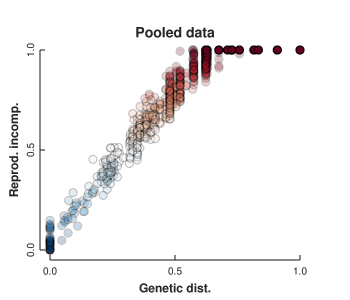

In [37]:
canvas = toyplot.Canvas(width=350, height=300)
axes = canvas.cartesian(
    label="Pooled data",
    xlabel="Genetic dist.",
    ylabel="Reprod. incomp.",
)

# points are jittered on x-axis for visibility
axes.scatterplot(
    data.genetic_dist,
    data.RI_pooled,
    size=8,
    opacity=0.25,
    color=data.loc[:, 'RI_pooled'].values,
    mstyle={"stroke": "black"},
);
axes.x.ticks.show = True
axes.y.ticks.show = True

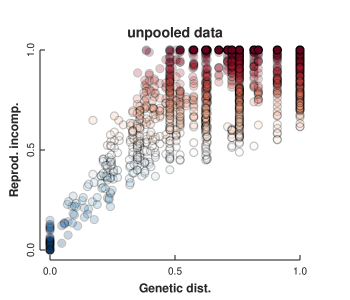

In [38]:
canvas = toyplot.Canvas(width=350, height=300)
axes = canvas.cartesian(
    label="unpooled data",
    xlabel="Genetic dist.",
    ylabel="Reprod. incomp.",
)

# points are jittered on x-axis for visibility
axes.scatterplot(
    data.genetic_dist,
    data.RI_unpooled,
    size=8,
    opacity=0.25,
    color=data.loc[:, 'RI_unpooled'].values,
    mstyle={"stroke": "black"},
);
axes.x.ticks.show = True
axes.y.ticks.show = True

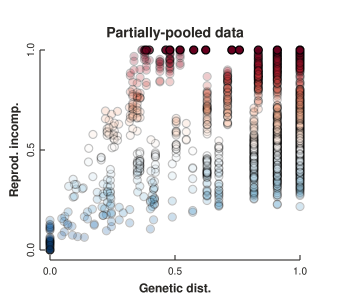

In [39]:
canvas = toyplot.Canvas(width=350, height=300)
axes = canvas.cartesian(
    label="Partially-pooled data",
    xlabel="Genetic dist.",
    ylabel="Reprod. incomp.",
)

# points are jittered on x-axis for visibility
axes.scatterplot(
    data.genetic_dist,
    data.RI_groups,
    size=8,
    opacity=0.25,
    color=data.loc[:, 'RI_groups'].values,
    mstyle={"stroke": "black"},
);
axes.x.ticks.show = True
axes.y.ticks.show = True

### Pairwise RI heatmap of sparse crossing data

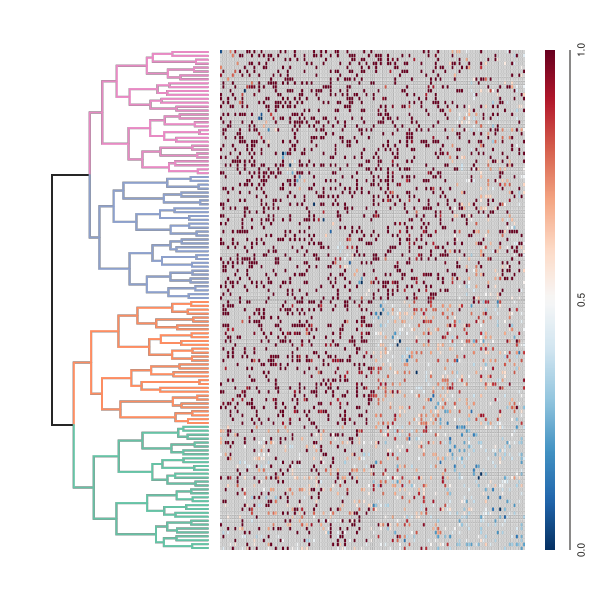

In [23]:
# get canvas size
canvas = toyplot.Canvas(width=600, height=600);

# colormap for values between 0-1
cmap = toyplot.color.LinearMap(domain_min=0, domain_max=1.0)

# add tree to canvas
ax0 = canvas.cartesian(bounds=(50, 210, 50, 550), show=False)
TREE.draw(
    axes=ax0, 
    layout='r', 
    tip_labels=False,
    edge_colors=TREE.get_edge_values_mapped({
        248: toytree.colors[0],
        249: toytree.colors[1],
        250: toytree.colors[2],
        251: toytree.colors[3],
    }),
);

# add heatmap to canvas
ax1 = canvas.table(rows=128, columns=128, bounds=(220, 525, 50, 550), margin=20)
for ridx in range(128):
    for cidx in range(128):
        
        # get RI for this cell
        d0 = data[(data.sidx0 == ridx) & (data.sidx1 == cidx)]
        d1 = data[(data.sidx1 == ridx) & (data.sidx0 == cidx)]
        
        # color cells if matxpat or patxmat cross in dataset
        if d0.size:
            col = cmap.color(d0.RI_groups.iloc[0])
            ax1.cells.cell[ridx, cidx].style = {
                "fill": col, "stroke": "none"
            }
        elif d1.size:
            col = cmap.color(d1.RI_groups.iloc[0])
            ax1.cells.cell[ridx, cidx].style = {
                "fill": col, "stroke": "none"
            }
            
        # if not in dataset then color it grey
        else:
            ax1.cells.cell[ridx, cidx].style = {
                "fill": "lightgrey", "stroke": "none"
            }

# style spacing between grid cells            
ax1.body.gaps.columns[...] = 0.5
ax1.body.gaps.rows[...] = 0.5

# add a colorbar to canvas
numberline = canvas.numberline(550, 550, 550, 50)
numberline.colormap(cmap, style={"stroke-width":5})

### (HYPOTHETICAL) heatmap of imputed cross probabilities given final parameters

After applying our hierarchical linear regression to estimate clade-specific rates of RI accumulation we can then estimate the RI between all species pairs based on the clade they belong to and the genetic distance between them. The final heatmap would look something like this, and we could color the tree by these values too.

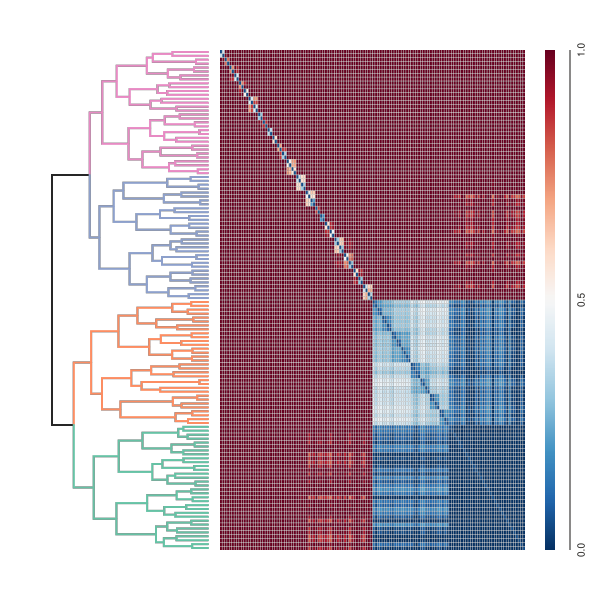

In [24]:
# get canvas size
canvas = toyplot.Canvas(width=600, height=600);

# colormap for values between 0-1
cmap = toyplot.color.LinearMap(domain_min=0, domain_max=1.0)

# add tree to canvas
ax0 = canvas.cartesian(bounds=(50, 210, 50, 550), show=False)
TREE.draw(
    axes=ax0, 
    layout='r', 
    tip_labels=False,
    edge_colors=TREE.get_edge_values_mapped({
        248: toytree.colors[0],
        249: toytree.colors[1],
        250: toytree.colors[2],
        251: toytree.colors[3],
    }),
);

maxdist = max([
    get_dist(TREE, i, j) / 2. for (i, j) in itertools.product(range(128), range(128))
])

# add heatmap
ax1 = canvas.table(rows=128, columns=128, bounds=(220, 525, 50, 550), margin=20)
for t0 in TREE.get_tip_labels():
    for t1 in TREE.get_tip_labels():

        # generate error
        ridx = name2nidx[t0]
        cidx = name2nidx[t1]
        dist = (get_dist(TREE, ridx, cidx) / 2.) / maxdist

        # get RI
        spp_effects = SPECIES_DATA.at[ridx, "𝜓_x"] + SPECIES_DATA.at[cidx, "𝜓_x"] 
        ri = 𝛼_mean + (𝛽_mean + spp_effects) * dist

        # normalize -- cannot be >1 or <0
        col = cmap.color(ri)
        ax1.cells.cell[ridx, cidx].style = {
            "fill": col, "stroke": "none"
        }

# dividers
ax1.body.gaps.columns[...] = 0.5
ax1.body.gaps.rows[...] = 0.5

# add a colorbar
numberline = canvas.numberline(550, 550, 550, 50)
numberline.colormap(cmap, style={"stroke-width":5})

# Bayesian model fitting

### Function to plotting posterior traces

In [40]:
def toytrace(trace, var_names, titles):
    """
    Plot posterior trace with toyplot
    """
    nvars = len(var_names)
    
    # setup canvase
    canvas = toyplot.Canvas(width=500, height=200 * nvars)
    
    # store axes
    axes = []
    
    # iter over params
    for pidx, param in enumerate(var_names):
        
        # get param posterior
        posterior = trace.get_values(param)
        
        # setup axes 
        ax = canvas.cartesian(grid=(nvars, 1, pidx))
        ax.y.show = False
        ax.x.spine.style = {"stroke-width": 1.5}
        ax.x.ticks.labels.style = {"font-size": "12px"}
        ax.x.ticks.show = True
        ax.x.label.text = f"param='{titles[pidx]}'"        
        
        # iterate over shape of param
        for idx in range(posterior.shape[1]):
            mags, bins = np.histogram(posterior[:, idx], bins=100)
            ax.plot(bins[1:], mags, stroke_width=2, opacity=0.6)
        axes.append(ax)
    return canvas, axes

<h2><i>Setup <span style="color:red">pooled</span> model</i></h2>

Treat all species the same, and estimate a single RI velocity.

$$ \text{RI}_{i,j} = \alpha + (\beta + \psi) X_{i,j} + \sigma $$

In [41]:
def censored_pooled_regression(x, y, **kwargs):
    
    # data pre-processing
    lower_censored = y[y <= 0].index
    _x_lc = x[lower_censored].values
    _y_lc = y[lower_censored].values

    upper_censored = y[y >= 1].index
    _x_uc = x[upper_censored].values
    _y_uc = y[upper_censored].values

    uncensored = (y > 0) & (y < 1)
    _x = x[uncensored].values
    _y = y[uncensored].values
    
    # define model
    with pm.Model() as model:  

        # parameters and error
        𝛼 = pm.Normal('𝛼', mu=0., sigma=10., shape=1)
        𝛽 = pm.Normal('𝛽', mu=0., sigma=10., shape=1)
        𝜎 = pm.HalfNormal('𝜎', 5.0, shape=1)

        # linear model prediction
        ri = 𝛼 + 𝛽 * _x

        # data likelihood (normal distributed errors)
        y = pm.Normal("y", mu=ri, sigma=𝜎, observed=_y)

        # density of censored data
        if sum(lower_censored):
            lcensored = pm.Potential(
                "lower_censored", 
                normal_lcdf(𝛼 + 𝛽 * _x_lc, 𝜎, _y_lc),
            )
        if sum(upper_censored):
            ucensored = pm.Potential(
                "upper_censored",
                normal_lccdf(𝛼 + 𝛽 * _x_uc, 𝜎, _y_uc),
            )

        # sample posterior, skip burnin
        trace = pm.sample(**kwargs)[1000:]
    
        # show summary table
        stats = pm.summary(trace)
        
    # organize results
    result_dict = {
        'model': model, 
        'trace': trace,
        'stats': stats,
    }
    return result_dict

<h2><i>Setup <span style="color:red">unpooled</span> model</i></h2>

Fit a different RI velocity to every species.

$$ \text{RI}_{i,j} = \alpha + (\beta + \psi_i + \psi_j) X_{i,j} + \epsilon $$

In [42]:
def censored_unpooled_noncentered_regression(x, y, idx0, idx1, **kwargs):
    
    # data pre-processing
    lower_censored = y[y <= 0].index
    _x_lc = x[lower_censored].values
    _y_lc = y[lower_censored].values

    upper_censored = y[y >= 1].index
    _x_uc = x[upper_censored].values
    _y_uc = y[upper_censored].values

    uncensored = (y > 0) & (y < 1)
    _x = x[uncensored].values
    _y = y[uncensored].values
    
    # define model
    with pm.Model() as model:
        
        # censored indexers
        sidx0 = pm.Data("spp_idx0", idx0.values[uncensored])
        sidx1 = pm.Data("spp_idx1", idx1.values[uncensored])
        sidx0_u = pm.Data("sidx0_u", idx0.values[upper_censored])
        sidx1_u = pm.Data("sidx1_u", idx1.values[upper_censored])
        sidx0_l = pm.Data("sidx0_l", idx0.values[lower_censored])
        sidx1_l = pm.Data("sidx1_l", idx1.values[lower_censored])

        # parameters and error
        𝜓_mean = pm.Normal('𝜓_mean', mu=0., sigma=5., shape=1)
        𝜓_std = pm.HalfNormal('𝜓_std', 5., shape=1)
        𝜓_offset = pm.Normal('𝜓_offset', mu=0, sigma=1., shape=128)
        𝜓 = pm.Deterministic('𝜓', 𝜓_mean + 𝜓_std * 𝜓_offset)
        𝛽 = pm.Normal('𝛽', mu=0., sigma=10., shape=1)
        𝛼 = pm.Normal('𝛼', mu=0., sigma=10., shape=1)
        𝜎 = pm.HalfNormal('𝜎', 5., shape=1)
        
        # linear model prediction
        ri = 𝛼 + (𝛽 + 𝜓[sidx0] + 𝜓[sidx1]) * _x

        # data likelihood (normal distributed errors)
        y = pm.Normal("y", mu=ri, sigma=𝜎, observed=_y)

        # density of censored data
        if sum(lower_censored):
            lcensored = pm.Potential(
                "lower_censored", 
                normal_lcdf(𝛼 + (𝛽 + 𝜓[sidx0_l] + 𝜓[sidx1_l]) * _x_lc, 𝜎, _y_lc),
            )
        
        if sum(upper_censored):
            ucensored = pm.Potential(
                "upper_censored",
                normal_lccdf(𝛼 + (𝛽 + 𝜓[sidx0_u] + 𝜓[sidx1_u]) * _x_uc, 𝜎, _y_uc),
            )

        # sample posterior, skip burnin
        trace = pm.sample(**kwargs)[1000:]

        # show summary table
        stats = pm.summary(trace)
        
    # organize results
    result_dict = {
        'model': model, 
        'trace': trace,
        'stats': stats,
    }
    return result_dict

<h2><i>Setup <span style="color:red">partially-pooled</span> model</i></h2>

Fit a different RI velocity to every species, but drawn from a hyperprior distribution for the clade/group they belong to.


$$ \psi_g \sim \mathcal{N}(\mu_g, \sigma^2_g) $$

$$ \text{RI}_{i,j} = \alpha + (\beta + \psi_{g,i} + \psi_{g,j})X_{i,j} + \sigma $$

In [43]:
def censored_partpooled_noncentered_regression(x, y, idx0, idx1, gidx, **kwargs):
    
    # data pre-processing
    lower_censored = y[y <= 0].index
    _x_lc = x[lower_censored].values
    _y_lc = y[lower_censored].values

    upper_censored = y[y >= 1].index
    _x_uc = x[upper_censored].values
    _y_uc = y[upper_censored].values

    uncensored = (y > 0) & (y < 1)
    _x = x[uncensored].values
    _y = y[uncensored].values
    
    # define model
    with pm.Model() as model:
        
        # censored indexers
        sidx0 = pm.Data("spp_idx0", idx0.values[uncensored])
        sidx1 = pm.Data("spp_idx1", idx1.values[uncensored])
        sidx0_u = pm.Data("sidx0_u", idx0.values[upper_censored])
        sidx1_u = pm.Data("sidx1_u", idx1.values[upper_censored])
        sidx0_l = pm.Data("sidx0_l", idx0.values[lower_censored])
        sidx1_l = pm.Data("sidx1_l", idx1.values[lower_censored])
        gidx = pm.Data("gidx", gidx)

        # parameters and error
        𝜓_mean = pm.Normal('𝜓_mean', mu=0., sigma=5., shape=4)
        𝜓_std = pm.HalfNormal('𝜓_std', 5., shape=4)
        𝜓_offset = pm.Normal('𝜓_offset', mu=0, sigma=1., shape=128)
        𝜓 = pm.Deterministic('𝜓', 𝜓_mean[gidx] + 𝜓_std[gidx] * 𝜓_offset)
        𝛽 = pm.Normal('𝛽', mu=0., sigma=10., shape=1)
        𝛼 = pm.Normal('𝛼', mu=0., sigma=10., shape=1)
        𝜎 = pm.HalfNormal('𝜎', 5., shape=1)
        
        # linear model prediction
        ri = 𝛼 + (𝛽 + 𝜓[sidx0] + 𝜓[sidx1]) * _x

        # data likelihood (normal distributed errors)
        y = pm.Normal("y", mu=ri, sigma=𝜎, observed=_y)

        # density of censored data
        if sum(lower_censored):
            lcensored = pm.Potential(
                "lower_censored", 
                normal_lcdf(𝛼 + (𝛽 + 𝜓[sidx0_l] + 𝜓[sidx1_l]) * _x_lc, 𝜎, _y_lc),
            )
        
        if sum(upper_censored):
            ucensored = pm.Potential(
                "upper_censored",
                normal_lccdf(𝛼 + (𝛽 + 𝜓[sidx0_u] + 𝜓[sidx1_u]) * _x_uc, 𝜎, _y_uc),
            )

        # sample posterior, skip burnin
        trace = pm.sample(**kwargs)[1000:]

        # show summary table
        stats = pm.summary(trace)
        
    # organize results
    result_dict = {
        'model': model, 
        'trace': trace,
        'stats': stats,
    }
    return result_dict

### MCMC Sample Parameters

In [61]:
# MCMC sampler kwargs
sample_kwargs = dict(
    tune=4000,
    draws=4000,
    target_accept=0.95,
    return_inferencedata=False,
    progressbar=True,
)

### Fit models to data generated under the pooled model

In [53]:
# model input
model_args = [
    data.genetic_dist,
    data.RI_pooled,
    data.sidx0,
    data.sidx1,
    SPECIES_DATA.gidx,
]

# fit pooled model to pooled data
pooled = censored_pooled_regression(*model_args[:2], **sample_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [𝜎, 𝛽, 𝛼]


Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 303 seconds.


In [ ]:
toytrace(pooled['trace'], ['𝛽'], ['𝛽']);

In [54]:
pooled['stats']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
𝛼[0],0.044,0.005,0.034,0.054,0.0,0.0,4459.0,4890.0,1.0
𝛽[0],1.511,0.011,1.490,1.531,0.0,0.0,4370.0,5067.0,1.0
𝜎[0],0.054,0.002,0.051,0.057,0.0,0.0,5269.0,5348.0,1.0


<div class='alert alert-info'>
Nailed it, these parameter estimates are correct.
</div>

### Fit models to data generated under the unpooled model

In [55]:
# model input
model_args = [
    data.genetic_dist,
    data.RI_unpooled,
    data.sidx0,
    data.sidx1,
    SPECIES_DATA.gidx,
]

# run models
unpooled = censored_unpooled_noncentered_regression(*model_args[:4], **sample_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [𝜎, 𝛼, 𝛽, 𝜓_offset, 𝜓_std, 𝜓_mean]


Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 18096 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 189 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 119 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


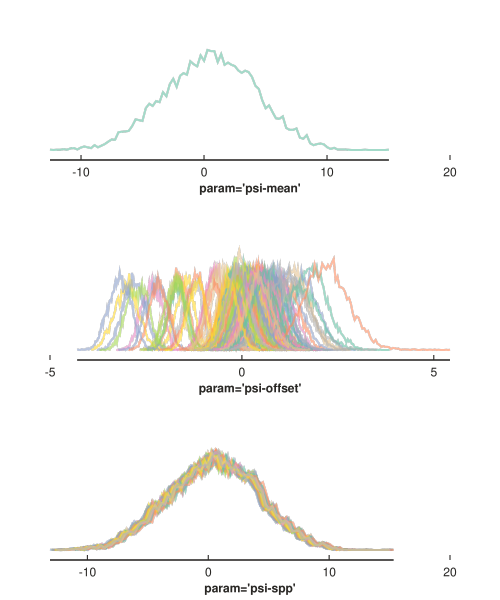

In [60]:
toytrace(unpooled['trace'], ['𝜓_mean', '𝜓_offset', '𝜓'], ['psi-mean', 'psi-offset', 'psi-spp']);

To assess how well this worked, let's check whether the species with higher estimated `psi-offset` also have higher TRUE Beta.

In [210]:
unpooled['trace'].varnames

['𝜓_mean', '𝜓_std_log__', '𝜓_offset', '𝛽', '𝛼', '𝜎_log__', '𝜓_std', '𝜓', '𝜎']

In [211]:
RI_ESTIMATE = (
    unpooled['trace']['𝛽'] + 
    unpooled['trace']['𝜓_mean'] + 
    unpooled['trace']['𝜓_std'] * 
    unpooled['trace']['𝜓_offset'].mean(axis=0)
).mean(axis=0)

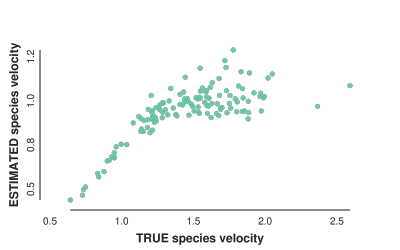

In [212]:
# show plot of TRUE vs. ESTIMATED rates
toyplot.scatterplot(
    SPECIES_DATA.velo,
    RI_ESTIMATE,
    width=400,
    height=250,
    xlabel="TRUE species velocity",
    ylabel="ESTIMATED species velocity"
);

<div class='alert alert-info'>
The correlation certainly seems close to expected. The variance increases a lot at the higher end which I expect is caused by the upper limit on RI (1.0) and the limits of what can be accomplished with censoring.
</div>

### Fit models to data generated under the part-pooled model

In [62]:
# model input
model_args = [
    data.genetic_dist,
    data.RI_groups,
    data.sidx0,
    data.sidx1,
    SPECIES_DATA.gidx,
]

In [63]:
partpooled = censored_partpooled_noncentered_regression(*model_args, **sample_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [𝜎, 𝛼, 𝛽, 𝜓_offset, 𝜓_std, 𝜓_mean]


Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 12019 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [69]:
partpooled['stats']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
𝜓_mean[0],1.825,2.463,-2.501,5.010,0.966,0.810,7.0,49.0,1.58
𝜓_mean[1],1.770,2.465,-2.557,4.961,0.967,0.806,7.0,70.0,1.58
𝜓_mean[2],1.478,2.468,-2.839,4.682,0.969,0.777,7.0,66.0,1.58
𝜓_mean[3],1.097,2.458,-3.240,4.264,0.962,0.713,7.0,47.0,1.58
𝜓_offset[0],-0.869,0.936,-1.958,0.977,0.340,0.255,7.0,43.0,1.54
...,...,...,...,...,...,...,...,...,...
𝜓[124],1.049,2.448,-3.264,4.205,0.955,0.708,7.0,49.0,1.57
𝜓[125],1.129,2.464,-3.226,4.290,0.966,0.716,7.0,47.0,1.59
𝜓[126],1.070,2.455,-3.253,4.248,0.960,0.712,7.0,48.0,1.57
𝜓[127],1.001,2.477,-3.321,4.223,0.975,0.723,7.0,41.0,1.58


In [88]:
partpooled['trace'].varnames

['𝜓_mean', '𝜓_std_log__', '𝜓_offset', '𝛽', '𝛼', '𝜎_log__', '𝜓_std', '𝜓', '𝜎']

In [207]:
RI_ESTIMATE = (
    partpooled['trace']['𝛽'] + 
    partpooled['trace']['𝜓_mean'][:, SPECIES_DATA.gidx] + 
    partpooled['trace']['𝜓_std'][:, SPECIES_DATA.gidx] * 
    partpooled['trace']['𝜓_offset'].mean(axis=0)
).mean(axis=0)

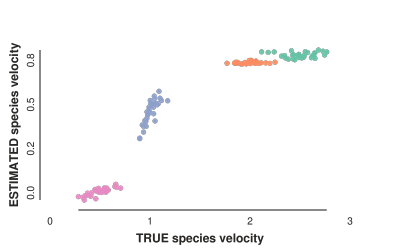

In [208]:
# show plot of TRUE vs. ESTIMATED rates
toyplot.scatterplot(
    SPECIES_DATA.velo_x,
    RI_ESTIMATE,
    width=400,
    height=250,
    xlabel="TRUE species velocity",
    ylabel="ESTIMATED species velocity",
    color=[toyplot.color.Palette()[i] for i in SPECIES_DATA.gidx],
);

<div class='alert alert-info'>
This is clearly able to separate out species to assign each a velocity according to their clade of origin, and it correctly identifies the order of velocities TRUE fast clades match ESTIMATED fast clades (not sure I made the colors line up with the earlier figures tho). Within each clade it also correctly assigns faster rates to species with true faster rates, but only within the two slowest clades, not in orange and green, likely because these clades are in the censored zone (RI>1). 
</div>

## Show Model Graphs

In [214]:
# pm.model_to_graphviz(pooled['model'])

In [215]:
# pm.model_to_graphviz(unpooled['model'])

In [216]:
# pm.model_to_graphviz(partpooled['model'])